In [1]:
import sys
import datetime as dt
import os.path

import math
import numpy as np
import cupy as cp
import ceo

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage
import scipy.interpolate as scyint
from collections import OrderedDict

import IPython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Initialize CEO objects
Make sure that the .ceo file containing the theoretical KL modes contains two sets (one for central, one for outer), and that the central KL pupil has the right OC ratio

In [2]:
#-- Karhunen-Loeve per M2 segment
M2_n_modes = 600 
gmt = ceo.GMT_MX(M2_mirror_modes=u"Karhunen-Loeve", M2_N_MODE=M2_n_modes)

In [3]:
D = 25.5
nPx = 1024
gs = ceo.Source("R",zenith=0.,azimuth=0., rays_box_size=D, 
        rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])

## Estimate central obscuration of central segment (S7)
From the optical design document (GMT-DOC-00010 Rev. F), the inner clear aperture (ICA) diameter (baffled) of S7 is 2875 mm, and the clear aperture diameter of all segments is 8365 mm. Hence, the central occultation ratio of S7 is:
$ \frac{2875}{8365}=0.344$.

Update 1): Based on the GMT-CAD-161007 Rev C, there is a M2 (circular) baffle 3.7 m in diameter. This becomes the dominant obstruction to compute the effective central occultation ratio of S7, becoming:
$ \frac{3700}{8365}=0.44232$.

Update 2): Based on new information, the M2 baffle will be reduced to 3.3 m in diameter, becoming: $ \frac{3300}{8365}=0.3945$.

In [4]:
gmt.reset()
gs.reset()
gmt.propagate(gs, project_truss_onaxis=True)

## Piston masks for each segment
P = np.rollaxis( np.array(gs.rays.piston_mask ),0,3)

## Find center coordinates (in pixels) of each segment mask
u = np.arange(gs.n)
v = np.arange(gs.m)
x,y = np.meshgrid(u,v)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P,axis=1)/P.sum(axis=1)
yc = np.sum(y*P,axis=1)/P.sum(axis=1)

## Polar coordinates
rho   = np.hypot(   x - xc[:,np.newaxis,:], y - yc[:,np.newaxis,:])   #temporal rho vector
theta = np.arctan2( y - yc[:,np.newaxis,:], x - xc[:,np.newaxis,:]) * P

In [5]:
##--- Method 2.
## Note: Uses radial profiles of segment masks to estimate radius and OC more precisely.

Roc_pix = []
Rs = []

for this_seg in range(7):
    nbins = np.round(rho[this_seg].max())
    Rflabel = np.rint(nbins * rho[this_seg]/rho[this_seg].max()).reshape((nPx,nPx))
    Rfidx = np.arange(0,Rflabel.max()+1)
    Sm = np.squeeze(P[this_seg,:]).reshape((nPx,nPx))
    Smprof = ndimage.mean(Sm, labels=Rflabel, index=Rfidx)
    midx = np.squeeze(np.argwhere(Smprof > 0))
    Roc_pix.append( np.where(midx[0] <=1, 0, midx[0]) ) #OC radius
    Rs.append( midx.max()+1) # Estimate semi-major axis

Roc_pix = np.array(Roc_pix)
Rs = np.array(Rs)
Roc = Roc_pix/Rs

print('Segment diameter estimation [m]: ')
print(np.array_str(Rs.ravel()*2*D/nPx, precision=3, suppress_small=True))

print("\nCentral occultation ratio for each segment: ")
print(np.array_str(Roc.ravel(), precision=3, suppress_small=True))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:639: RuntimeWarning: invalid value encountered in true_divide
  return sum / numpy.asanyarray(count).astype(numpy.float)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


Segment diameter estimation [m]: 
[8.367 8.367 8.367 8.367 8.367 8.367 8.317]

Central occultation ratio for each segment: 
[0.    0.    0.    0.    0.    0.    0.395]


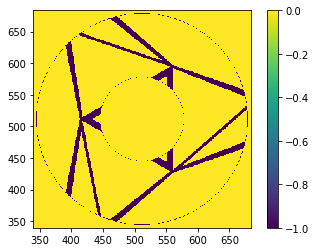

In [6]:
# Show quality of central segment fitting
this_seg=6
Sm = np.squeeze(P[this_seg,:]).reshape((nPx,nPx))
Sf = np.squeeze(np.logical_and(rho[this_seg,:]<Rs[this_seg], rho[this_seg,:]>Roc[this_seg]*Rs[this_seg])).reshape((nPx,nPx))

#plt.imshow(Sm.astype('int'), interpolation='None')
plt.imshow(Sm.astype('int')-Sf.astype('int'), interpolation='None')
plt.xlim([xc[this_seg]-Rs[this_seg]-5, xc[this_seg]+Rs[this_seg]+5])
plt.ylim([yc[this_seg]-Rs[this_seg]-5, yc[this_seg]+Rs[this_seg]+5])
plt.colorbar()

## Retrieve Rod's KL modes
*Note:* There are two sets: 
1. one for outer segments;
2. one for the central segment. (Rod updated the M2_KarhunenLoeve.ceo file with theoretical KL modes defined in a circular pupil with the requested OC ratio)

In [7]:
## Retrieve M2 KL modes
M2 = gmt.M2.modes.M.host()
print(M2.shape)

(65536, 2000)


In [53]:
## Select central segment OC
OC_S7 = 0.3945
#OC_S7 = 0.344
#OC_S7 = 0.359 

In [54]:
#Create circular mask 
rows = gmt.M2.modes.N_SAMPLE
cols = gmt.M2.modes.N_SAMPLE
nsets = gmt.M2.modes.N_SET
nkls = gmt.M2.modes.N_MODE

xVec = np.linspace(-1,1,cols)
yVec = np.linspace(-1,1,rows)
[x,y] = np.meshgrid(xVec,yVec) # rows x cols
r = np.hypot(x,y)

#Mask for outer segments
M2masko = np.full((rows,cols),np.nan)
M2masko[(r <= 1)]=1.0
M2npo = np.sum(r <= 1)

#Mask for central segment
M2maskc = np.full((rows,cols),np.nan)
M2maskc[np.logical_and(r <= 1, r >= OC_S7)] = 1.0
M2npc = np.sum(M2maskc == 1)

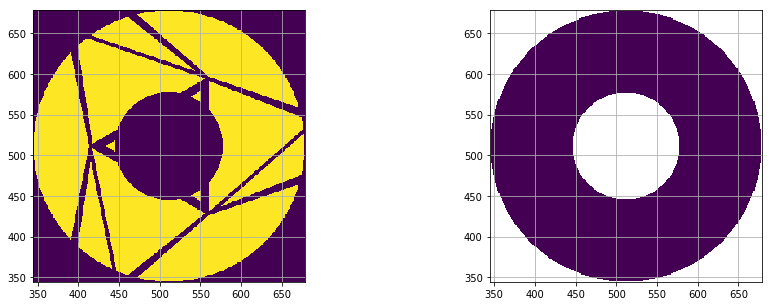

In [57]:
#### Check visually that the mask for central segment matches the actual segment pupil mask

this_seg=6
extenttt = np.squeeze([xc[this_seg]-Rs[this_seg], xc[this_seg]+Rs[this_seg], yc[this_seg]-Rs[this_seg], yc[this_seg]+Rs[this_seg]])
Sm = np.squeeze(P[this_seg,:]).reshape((nPx,nPx))

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)

imm = ax1.imshow(Sm, interpolation='None')#, extent=[-1,1,-1,1])
ax1.set_xlim([xc[this_seg]-Rs[this_seg], xc[this_seg]+Rs[this_seg]])
ax1.set_ylim([yc[this_seg]-Rs[this_seg], yc[this_seg]+Rs[this_seg]])
ax1.grid()

imm1 = ax2.imshow(M2maskc, extent=extenttt)
ax2.grid()

RMS of KL mode 596 of set 1 is: 0.71


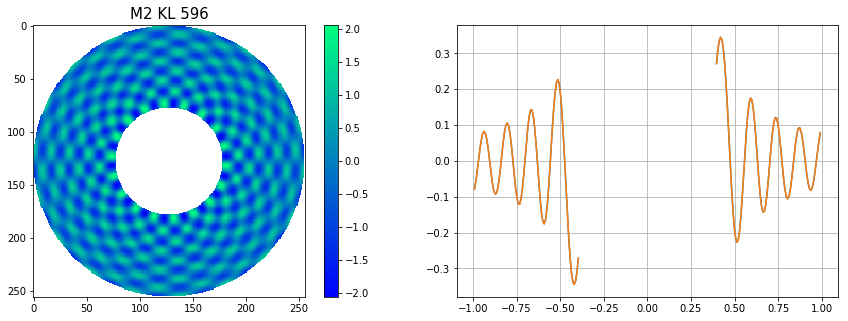

In [79]:
## Choose KL to display
this_set = 1    # 0: outer segments;    1: central segment
this_kl = 596

if this_set == 0:
    M2mask = M2masko
    M2np = M2npo
else:
    M2mask = M2maskc
    M2np = M2npc

KLmap = np.reshape(M2[:,this_set*nkls+this_kl], (rows,cols) )*M2mask
KLrms = np.sqrt( np.sum(KLmap[M2mask==1]**2)/M2np )
print("RMS of KL mode %d of set %d is: %.2f"%(this_kl, this_set, KLrms))

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(KLmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M2 KL %d'%(this_kl), fontsize=15)

ax2.plot(xVec,KLmap[:,int(cols/2)])
ax2.plot(yVec,KLmap[int(rows/2),:])
ax2.grid()

## Compute the cross-product matrix

In [80]:
## Choose set to process
this_set = 1    # 0: outer segments;    1: central segment

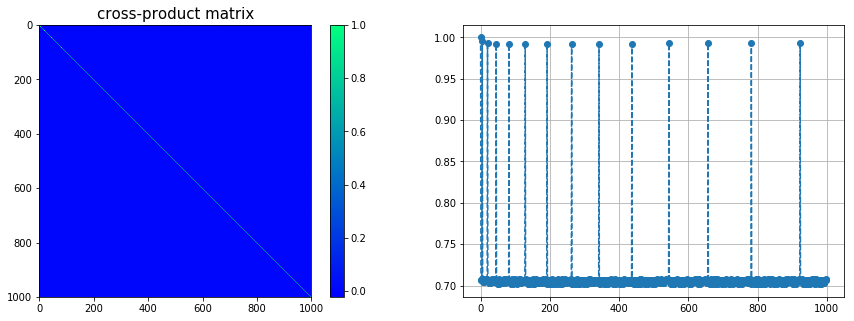

In [81]:

if this_set == 0:
    M2mask = M2masko
    M2np = M2npo
else:
    M2mask = M2maskc
    M2np = M2npc

KLmat = []
for ii in range(nkls):
    KLmap = np.reshape(M2[:,this_set*nkls+ii], (rows,cols) )*M2mask
    KLmat.append( KLmap[M2mask==1])

KLmat = np.transpose(KLmat)
Dmat = np.matmul(np.transpose(KLmat), KLmat)/M2np;

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(Dmat, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('cross-product matrix', fontsize=15)

ax2.plot(np.sqrt(np.diag(Dmat)), 'o--')
ax2.grid()

In [82]:
## KL modes that have large RMS w.r.t to the majority (as seen in plot above)
np.where(np.sqrt(np.diag(Dmat)) > 0.9)

(array([  0,   5,  20,  45,  82, 129, 192, 263, 342, 437, 544, 657, 782,
        923]),)

## Re-orthonormalize KL modes

Text(0, 0.5, 'normalized singular value')

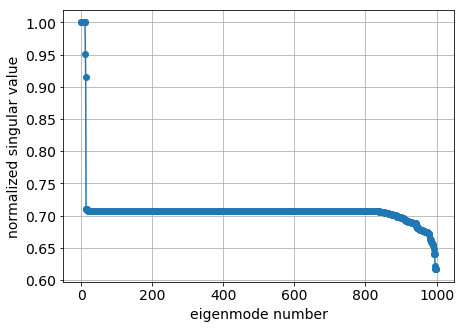

In [83]:
Lmat = np.linalg.cholesky(Dmat)
Umat, Smat, Vmat =np.linalg.svd(Lmat)

fig, ax = plt.subplots()
fig.set_size_inches(7,5)

ax.plot(Smat/np.max(Smat), 'o-', )
ax.grid()
ax.tick_params(labelsize=14)
ax.set_xlabel('eigenmode number', fontsize=14)
ax.set_ylabel('normalized singular value', fontsize=14)
#ax.set_xlim([2400,2500])

(0, 1.2)

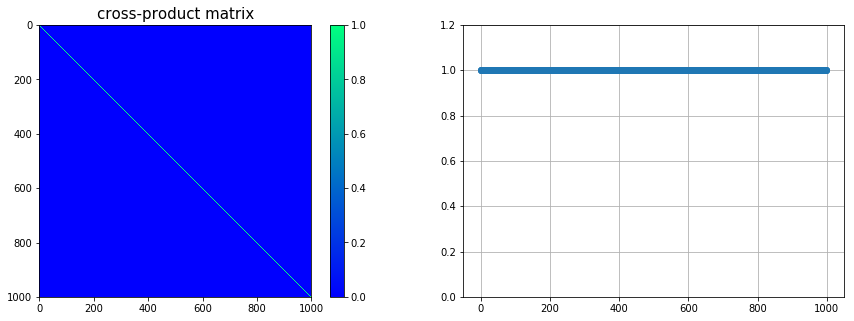

In [84]:
inv_cond = 1e-12
inv_Lmat = np.linalg.pinv(Lmat, rcond=inv_cond)
KLmato = np.matmul(KLmat, np.transpose(inv_Lmat))
Dmato = np.matmul(np.transpose(KLmato), KLmato)/M2np;

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(Dmato, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('cross-product matrix', fontsize=15)

ax2.plot(np.diag(Dmato), 'o--')
ax2.grid()
ax2.set_ylim([0,1.2])

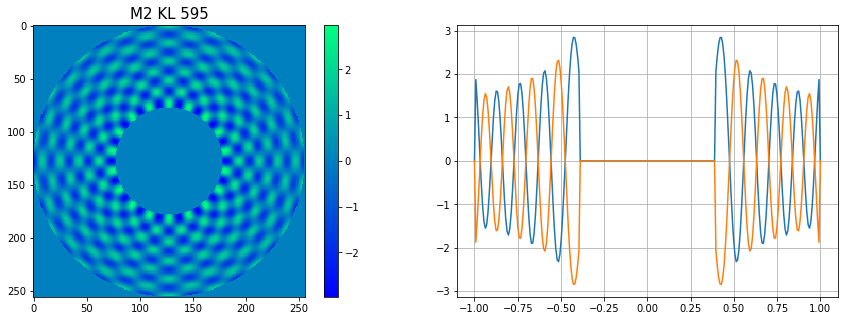

In [87]:
## Visualize re-ortho modes
this_kl=595
KLmap = np.zeros((rows,cols))
KLmap[M2mask==1] = KLmato[:,this_kl]

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(KLmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M2 KL %d'%(this_kl), fontsize=15)

ax2.plot(xVec,KLmap[:,int(cols/2)])
ax2.plot(yVec,KLmap[int(rows/2),:])
ax2.grid()

## Create set of pure segment piston, tip, and tilt

In [88]:
PTTmat = np.zeros((M2np,3))
PTTmat[:,0] = 1
PTTmat[:,1] = x[M2mask==1]
PTTmat[:,2] = y[M2mask==1]

PTT_Dmat = np.matmul(np.transpose(PTTmat), PTTmat)/M2np;
PTT_Lmat = np.linalg.cholesky(PTT_Dmat)
PTT_inv_Lmat = np.linalg.pinv(PTT_Lmat)
PTTmato = np.matmul(PTTmat, np.transpose(PTT_inv_Lmat))

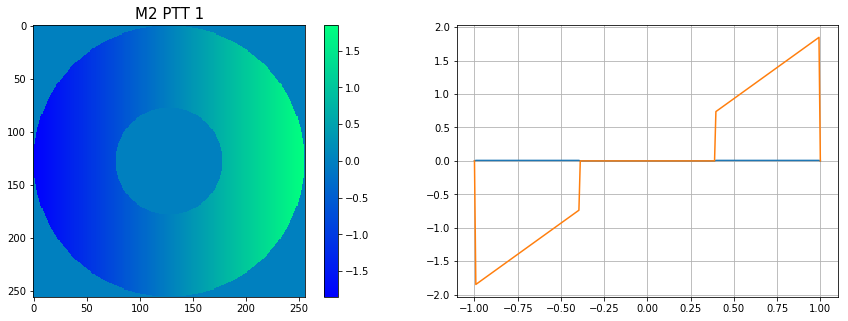

In [90]:
## Visualize PTT modes
this_kl=1
KLmap = np.zeros((rows,cols))
KLmap[M2mask==1] = PTTmato[:,this_kl]

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(KLmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M2 PTT %d'%(this_kl), fontsize=15)

ax2.plot(xVec,KLmap[:,int(cols/2)])
ax2.plot(yVec,KLmap[int(rows/2),:])
ax2.grid()

## Remove PTT from all KL modes, and merge with pure PTT modes

In [91]:
inv_PTTmato = np.linalg.pinv(PTTmato)
ptt_coeffs = np.matmul(inv_PTTmato, KLmato)
KLmato_pttf = KLmato - np.matmul(PTTmato, ptt_coeffs)

ModesMat = np.hstack((PTTmato, KLmato_pttf[:,3:]))

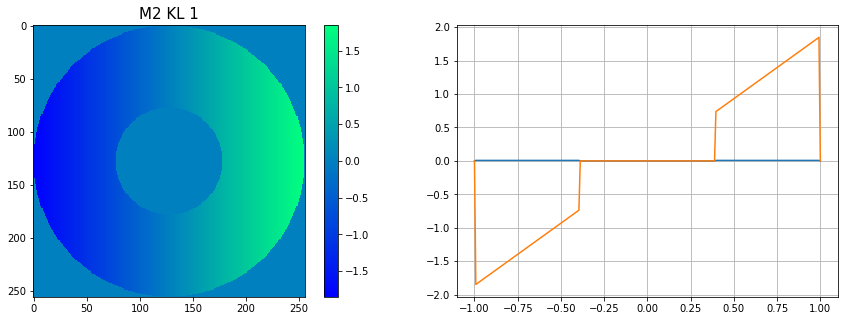

In [92]:
## Visualize final modes
this_kl=1
KLmap = np.zeros((rows,cols))
KLmap[M2mask==1] = ModesMat[:,this_kl]

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(KLmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M2 KL %d'%(this_kl), fontsize=15)

ax2.plot(xVec,KLmap[:,int(cols/2)])
ax2.plot(yVec,KLmap[int(rows/2),:])
ax2.grid()

## Extrapolate outside pupil (required by CEO)

In [93]:
#--- Extrapolate (using near-neighbor method) to points outside mirror
ModesMatCEO = np.zeros((rows,cols,nkls))
maskOffOut = np.logical_and(np.isnan(M2mask), r >= 0.9) # points outside circle
maskOffIn  = np.logical_and(np.isnan(M2mask), r <= 0.9) # points within OC
pointsData = np.concatenate([x[  M2mask==1][:,None], y[  M2mask==1][:,None]],axis=1)
pointsOut  = np.concatenate([x[ maskOffOut][:,None], y[ maskOffOut][:,None]],axis=1)
pointsIn   = np.concatenate([x[  maskOffIn][:,None], y[  maskOffIn][:,None]],axis=1)


for this_kl in range(nkls):
    ModesMatCEO[M2mask==1,this_kl] = ModesMat[:,this_kl]
    ModesMatCEO[maskOffOut,this_kl] = scyint.griddata(pointsData, ModesMatCEO[M2mask==1,this_kl], pointsOut, method='nearest')
    if this_set == 1:
        ModesMatCEO[ maskOffIn,this_kl] = scyint.griddata(pointsData, ModesMatCEO[M2mask==1,this_kl],  pointsIn, method='cubic')
    

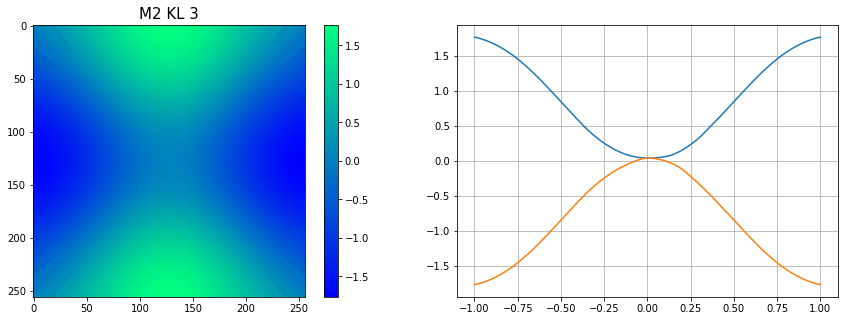

In [94]:
## Visualize extrapolated modes
this_kl=3
KLmap = ModesMatCEO[:,:,this_kl]

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(KLmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M2 KL %d'%(this_kl), fontsize=15)

ax2.plot(xVec,KLmap[:,int(cols/2)])
ax2.plot(yVec,KLmap[int(rows/2),:])
ax2.grid()

In [78]:
### save outer KL modes to KL1
KL1 = []
for this_kl in range(nkls):
    KL1.append(ModesMatCEO[:,:,this_kl])

In [95]:
### save central segment KL modes to KL2
KL2 = []
for this_kl in range(nkls):
    KL2.append(ModesMatCEO[:,:,this_kl])

In [96]:
suit = OrderedDict()
suit['Ni']     = np.array( rows,  dtype=np.int32) #assume number of rows = number of cols
suit['L']      = np.array( 1.05,  dtype=np.double) # size of M2 segment
suit['N_SET']  = np.array( 2,     dtype=np.int32)
suit['N_MODE'] = np.array( len(KL1),     dtype=np.int32)
suit['s2b']    = np.array( [0,0,0,0,0,0,1], dtype=np.int32)
suit['M'] = np.dstack(KL1+KL2).flatten(order='F')
path_to_modes  = '/storage/data02/gmtMirrors_repository/M2_KarhunenLoeveModes_ortho_S7OC%1.3f_cubicInt.ceo'%OC_S7
with open(path_to_modes,'w') as f:
    for key in suit:
        suit[key].tofile(f)